INTENT: other
No response


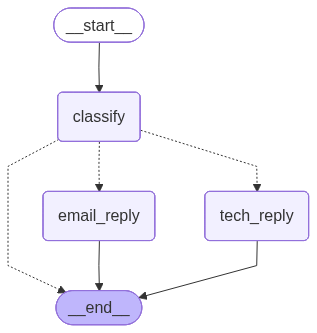

In [ ]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from IPython.display import Image, display


llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.2)

class State(TypedDict):
    user_msg: str
    intent: Literal["tech", "email", "other"]
    response: str

def classify(state: State):
    prompt = f"""
Classify intent as exactly one of: tech, email, other.
Message: {state['user_msg']}
Only output: tech OR email OR other
"""
    intent = llm.invoke(prompt).content.strip().lower()
    if intent not in ("tech", "email", "other"):
        intent = "other"
    return {"intent": intent}

def tech_reply(state: State):
    msg = llm.invoke(f"Answer this technical question clearly with steps:\n{state['user_msg']}")
    return {"response": msg.content}

def email_reply(state: State):
    msg = llm.invoke(f"Draft a professional email reply:\n{state['user_msg']}")
    return {"response": msg.content}

def route(state: State):
    return "tech_reply" if state["intent"] == "tech" else "email_reply" if state["intent"] == "email" else END

g = StateGraph(State)
g.add_node("classify", classify)
g.add_node("tech_reply", tech_reply)
g.add_node("email_reply", email_reply)

g.set_entry_point("classify")
g.add_conditional_edges("classify", route, {
    "tech_reply": "tech_reply",
    "email_reply": "email_reply",
    END: END
})
g.add_edge("tech_reply", END)
g.add_edge("email_reply", END)

graph = g.compile()

out = graph.invoke({"user_msg": "CDraft a professional email asking when I will receive the status report."})
print("INTENT:", out.get("intent"))
print(out.get("response", "No response"))

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))